#### **Step 0. Loading the Data from File Path**
- Download Data
- Import Libraries

In [81]:
import numpy as np
import pandas as pd
import prophet

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from keras.optimizers import Adam

In [82]:
from google.colab import drive # Load data from google drive
drive.mount("/content/drive")

%cd "/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C"
%ls -f

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C
data/                        data_2_preprocess.ipynb
data_econ.gsheet             data_financials.csv
data_financials.gsheet       data_econ.csv
combined_2.csv               train_1.csv
preprocessed_Dataset_2.csv   test_1.csv
result.csv                   preprocessed_test_1.csv
result_2.csv                 preprocessed_train_1.csv
result_accuracy_0.03.gsheet  data_1_preprocess.ipynb
result_accuracy_0.58.gsheet  model_train.ipynb
result_accuracy_0.86.gsheet  LSTM_Model_Train.ipynb


In [83]:
train_1 = pd.read_csv("preprocessed_train_1.csv")
test_1 = pd.read_csv("preprocessed_test_1.csv")

In [84]:
y_train_1 = train_1["Y"]
X_train_1 = train_1.drop(columns = ["Y"])

y_test_1 = test_1["Y"]
X_test_1 = test_1.drop(columns = ["Y"])

In [85]:
X_train_1_prev_bond_rating = X_train_1.pop("Prev Bond Rating Rank")
prev_bond_rating_rank = X_test_1.pop("Prev Bond Rating Rank")

#### **Step 1. Model Training**
- Generate Y-value
- Train the Model

In [86]:
from sklearn.model_selection import train_test_split

# Reshape the data for LSTM input
n_samples = X_train_1.shape[0]
n_features = X_train_1.shape[1]
n_timesteps = 3

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_1, y_train_1, test_size = 1/9, shuffle = False)

In [87]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


X_train, y_train = [], []
for i in range(0, y_train_1.shape[0] - (n_timesteps - 1)):
  X_train.append(X_train_1.iloc[i : i + n_timesteps].values)
  y_train.append(y_train_1.iloc[i + (n_timesteps - 1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)

# Encode the target variable
y_train = to_categorical(y_train)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(0, y_test_1.shape[0] - (n_timesteps - 1)):
  X_test.append(X_test_1.iloc[i : i + n_timesteps].values)
  y_test.append(y_test_1.iloc[i + (n_timesteps - 1)])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)

# Encode the target variable
y_test = to_categorical(y_test)
print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (707, 3, 600), (707, 17)
Test data dimensions: (87, 3, 600), (87, 17)


In [88]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l1, l2
from time import time

In [89]:
# A list of CONSTANTS for modelling:

LAYERS = [64, 17]                   # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
T = n_timesteps                      # number of timestpes
BATCH = M_TRAIN                      # batch size
EPOCH = 100                           # number of epochs
LR = 0.005                           # learning rate of the gradient descent
LAMBD = 0.03                         # lambda in L2 regularizaion
DP = 0.4                             # dropout rate
RDP = 0.4                          # recurrent dropout rate

print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

layers=[64, 17], train_examples=707, test_examples=87
batch = 707, timesteps = 3, features = 600, epochs = 100
lr = 0.005, lambda = 0.03, dropout = 0.4, recurr_dropout = 0.4


In [90]:
# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
# model.add(LSTM(units=LAYERS[1],
#                activation='tanh', recurrent_activation='hard_sigmoid',
#                kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#                dropout=DP, recurrent_dropout=RDP,
#                return_sequences=False, return_state=False,
#                stateful=False, unroll=False
#               ))
# model.add(BatchNormalization())
model.add(Dense(units=LAYERS[1], activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=LR))
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                170240    
                                                                 
 batch_normalization_10 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 17)                1105      
                                                                 
Total params: 171,601
Trainable params: 171,473
Non-trainable params: 128
_________________________________________________________________
None


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 16.0701 - accuracy: 0.0651 - val_loss: 13.7104 - val_accuracy: 0.1149 - lr: 0.0050
Epoch 2/100
1/1 [==============================] - 0s 158ms/step - loss: 13.2892 - accuracy: 0.3253 - val_loss: 12.0275 - val_accuracy: 0.2299 - lr: 0.0050
Epoch 3/100
1/1 [==============================] - 0s 156ms/step - loss: 11.2121 - accuracy: 0.5248 - val_loss: 10.5435 - val_accuracy: 0.3333 - lr: 0.0050
Epoch 4/100
1/1 [==============================] - 0s 180ms/step - loss: 9.5048 - accuracy: 0.5941 - val_loss: 9.2463 - val_accuracy: 0.4138 - lr: 0.0050
Epoch 5/100
1/1 [==============================] - 0s 165ms/step - loss: 8.1237 - accuracy: 0.6238 - val_loss: 8.1245 - val_accuracy: 0.4483 - lr: 0.0050
Epoch 6/100
1/1 [==============================] - 0s 171ms/step - loss: 6.8814 - accuracy: 0.6421 - val_loss: 7.1668 - val_accuracy: 0.4598 - lr: 0.0050
Epoch 7/100
1/1 [==============================] - 0s 164ms/step - loss: 

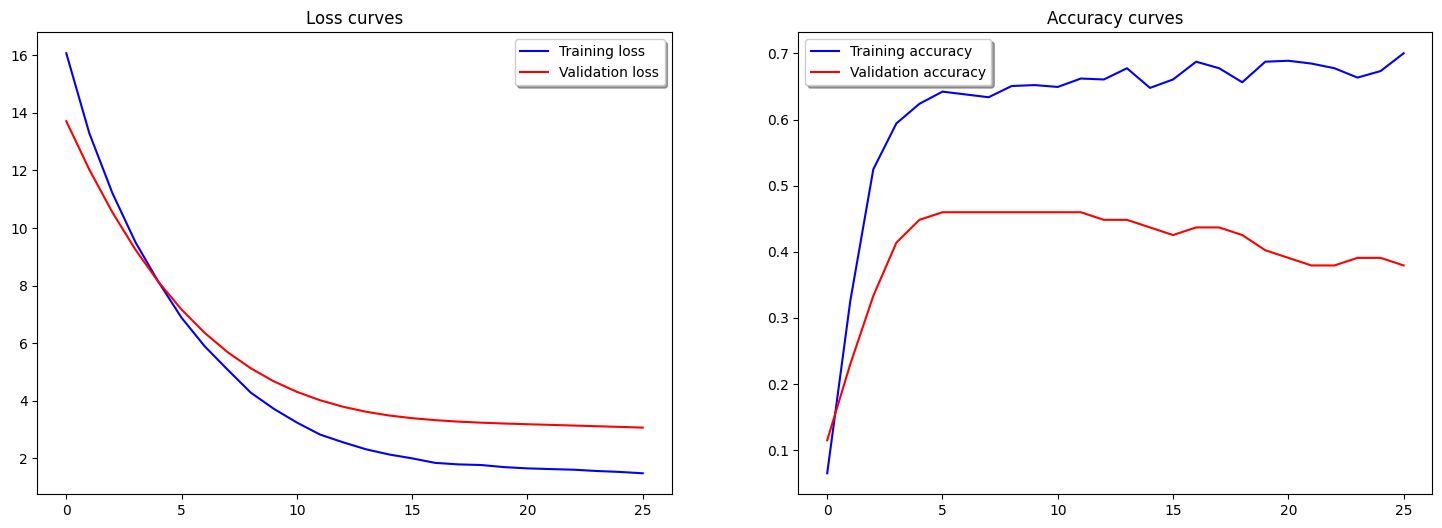

In [91]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss',
                             patience=1, verbose=0,
                             factor=0.25, min_lr=1e-8)
# Define Early Stopping:
early_stop_acc = EarlyStopping(monitor='val_accuracy', min_delta=0,
                               patience=20, verbose=1, mode='auto',
                               baseline=0, restore_best_weights=True)

early_stop_loss = EarlyStopping(monitor='val_loss', min_delta=0,
                               patience=20, verbose=1, mode='auto',
                               baseline=0, restore_best_weights=True)

History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_test[:M_TEST], y_test[:M_TEST]),
                    shuffle=False,verbose=1,
                    callbacks=[lr_decay, early_stop_acc, early_stop_loss])

# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=1)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)

axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()